In [10]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import matplotlib.font_manager as pltfont
from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap
from scipy import spatial, stats
from scipy.stats import fisher_exact
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import fcluster
from statsmodels import stats
import statsmodels.stats.multitest as multi
from typing import List
from collections import Counter
from pyhpo import Ontology, HPOSet
from HPO_functions import *
from clustering_functions import *
_ = Ontology()

# Import font for plots
font_dirs = ["/Users/alicesmail/Desktop"]  
font_files = pltfont.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files: pltfont.fontManager.addfont(font_file)

# -------------------------------------------------------------------

### **Import pre-processed and filtered DECIPHER dataset**
- Remove patients with fewer than 4 associated HPO terms.

In [11]:
# Read DECIPHER csv & filter
decipher_data = pd.read_csv('decipher_data_filtered.csv')
decipher_data = decipher_data[(decipher_data["pathogenicity"] == "Pathogenic") | (decipher_data["pathogenicity"] == "Likely pathogenic")]
decipher_data = decipher_data[decipher_data['phenotype_names'].notna()]

# Remove rows where the length of the list of HPO terms is less than 4.
decipher_data_filtered = decipher_data[decipher_data['hpo_terms_freq'] > 3]

# Find the number of patients remaining (399 patients)
num_rows = decipher_data_filtered.shape[0]

- Remove redundant HPO terms, identify IQR and approximately equalise the number of HPO terms per patient

In [12]:
# Identify outliers using the interquartile range for hpo_list
decipher_data_filtered['hpo_list'] = decipher_data_filtered['hpo_accessions'].str.split('|')
q1 = decipher_data_filtered['hpo_list'].apply(len).quantile(0.25)
q3 = decipher_data_filtered['hpo_list'].apply(len).quantile(0.75) 

# Calculate interquartile range and upper/lower outliers
iqr = q3 - q1
lower_outlier = q1 - 1.5 * iqr
upper_outlier = q3 + 1.5 * iqr

# Remove HPO terms that are less relevant to clustering (such as modifier and obsolete terms) 
decipher_data_filtered = decipher_data_filtered.reset_index(drop=True)
decipher_data_filtered['hpo_set'] = decipher_data_filtered['hpo_list'].apply(HPOSet.from_queries)
decipher_data_filtered['hpo_set'] = decipher_data_filtered['hpo_set'].apply(HPOSet.remove_modifier)
decipher_data_filtered['hpo_set'] = decipher_data_filtered['hpo_set'].apply(HPOSet.replace_obsolete)
decipher_data_filtered['hpo_set'] = decipher_data_filtered['hpo_set'].apply(HPOSet.child_nodes)
decipher_data_filtered['hpo_list'] = decipher_data_filtered['hpo_set'].apply(get_hpo_list)

# Select patients that have a greater number of HPO terms than the upper outlier
decipher_upper_outliers = decipher_data_filtered[decipher_data_filtered['hpo_list'].apply(len) > upper_outlier]

# Filter by retaining HPO terms with the highest IC (information content) up to the upper outlier number of HPO terms
decipher_upper_outliers['filtered_hpo_list'] = decipher_upper_outliers['hpo_set'].apply(filter_highest_ic_terms, max_number_of_terms=int(upper_outlier), list_or_object='list')
decipher_upper_outliers['filtered_hpo_set'] = decipher_upper_outliers['filtered_hpo_list'].apply(HPOSet.from_queries)
merge_temp = decipher_data_filtered.merge(decipher_upper_outliers, how='left', left_index=True, right_index=True)
decipher_data_filtered['filtered_hpo_list'] = merge_temp['filtered_hpo_list'].fillna(merge_temp['hpo_list_x'])
decipher_data_filtered['filtered_hpo_set'] = merge_temp['filtered_hpo_set'].fillna(merge_temp['hpo_set_x'])
decipher_data_filtered = decipher_data_filtered.reset_index()

/var/folders/hw/lt7xkjh55hz1_s2z24sn1srh0000gn/T/ipykernel_66540/3169900103.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  decipher_data_filtered['hpo_list'] = decipher_data_filtered['hpo_accessions'].str.split('|')
/var/folders/hw/lt7xkjh55hz1_s2z24sn1srh0000gn/T/ipykernel_66540/3169900103.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  decipher_upper_outliers['filtered_hpo_list'] = decipher_upper_outliers['hpo_set'].apply(filter_highest_ic_terms, max_number_of_terms=int(upper_outlier), list_or_o

- Compute similarity between patients

In [13]:
# Convert the pyhpo similarity function into a vectorized function
vsim = np.vectorize(HPOSet.similarity)

# Create two matrices that correspond with the pairs to compare in the next step
x, y = np.meshgrid(decipher_data_filtered['filtered_hpo_set'], decipher_data_filtered['filtered_hpo_set'])

# Semantic similarity is computed via the Graphic method, which checks for the sum of the IC of the common ancestors divided by the sum of the IC of the combined (union) parents of both terms (1 = identical terms) 
# The 'funSimAvg' method combines term-term similarity scores into set-set similarity scores
method, combine = 'graphic', 'funSimAvg'

# Run HPOSet.similarity on the whole of the two matrices
result = vsim(x, y, kind='omim', method=method, combine=combine)

- Create distance matrix and dendrogram

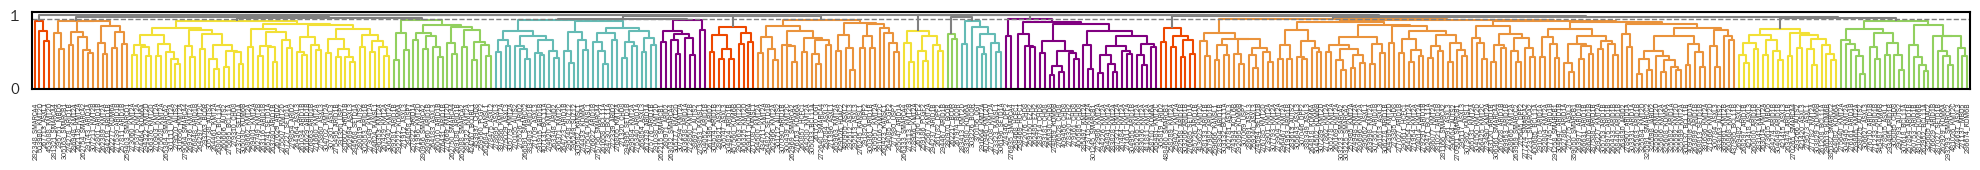

In [14]:
# Create patient identifiers
decipher_data_filtered['patient_id'] = (decipher_data_filtered["# patient_id"]).astype(str) + "_" +  (decipher_data_filtered["gene"]).astype(str) 
decipher_data_filtered.index = decipher_data_filtered['patient_id']

# Set methods to use
affinity, linkage_method = 'precomputed', 'complete'

# Convert result to pandas dataframe and add header and index.
graphic_hpo_similarity = pd.DataFrame(result, index=decipher_data_filtered.index, columns=decipher_data_filtered.index)

# Convert the similarity matrix to a distance matrix: now 0 equals zero distance between terms, therefore identical terms = 0 -> This will be the input for the hierarchical cluster analysis.
graphic_hpo_distance = pd.DataFrame(np.max(result)-(np.array(result)), index=decipher_data_filtered.index, columns=decipher_data_filtered.index)

# Convert distance matrix to distance vector.
condenced_distance_1D = spatial.distance.squareform(np.max(result)-(np.array(result)), force='tovector', checks=False)

# Calculate hierarchical linkage from the distance vector.
linkage = hierarchy.linkage(condenced_distance_1D, method = linkage_method)

# Plot dendrogram without heatmap
custom_params = {"axes.edgecolor": 'black', "axes.linewidth": 1.5}
plt.figure(figsize=(25, 1))
sns.set_theme(style= 'whitegrid', font_scale=1, font="Franklin Gothic Book", rc=custom_params)
hierarchy.set_link_color_palette(['#ee4800', '#ea933c', '#f2e036', '#92d05f', '#65bbb5', 'purple'])
hierarchy.dendrogram(linkage, labels=graphic_hpo_similarity.index, color_threshold=0.95, above_threshold_color='grey', leaf_font_size=5)
plt.axhline(y=0.95, c='grey', lw=1, linestyle='dashed')
plt.xticks(rotation=90)
plt.grid()
plt.show()

- From the dendrogram, it was decided that n=12 clusters, using a threshold of 0.95, was ideal to try and identify specific phenotypic clusters

In [15]:
# Perform clustering
clustering = AgglomerativeClustering(n_clusters=12, affinity=affinity, linkage=linkage_method).fit(graphic_hpo_distance)

# Add information for each patient
labels = clustering.labels_ + 1
decipher_data_filtered['cluster'] = labels
decipher_data_filtered['filtered_hpo_list_length'] = decipher_data_filtered['filtered_hpo_list'].apply(len)

/Users/alicesmail/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


- The following graphs were made to check that clusters are not largely driven by HPO term frequency
- While there is still a large range in the number of terms per patient, no one cluster appears to be driven by HPO frequency

/var/folders/hw/lt7xkjh55hz1_s2z24sn1srh0000gn/T/ipykernel_66540/3524720484.py:18: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.catplot(x='cluster', y='filtered_hpo_list_length', data=decipher_data_filtered, palette=['#ee4800', '#ea933c', '#f2e036', '#92d05f', '#65bbb5', 'purple'], height=3, aspect=2)
/var/folders/hw/lt7xkjh55hz1_s2z24sn1srh0000gn/T/ipykernel_66540/3524720484.py:18: UserWarning: 
The palette list has fewer values (6) than needed (12) and will cycle, which may produce an uninterpretable plot.
  sns.catplot(x='cluster', y='filtered_hpo_list_length', data=decipher_data_filtered, palette=['#ee4800', '#ea933c', '#f2e036', '#92d05f', '#65bbb5', 'purple'], height=3, aspect=2)
/Users/alicesmail/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_n

<Figure size 640x480 with 0 Axes>

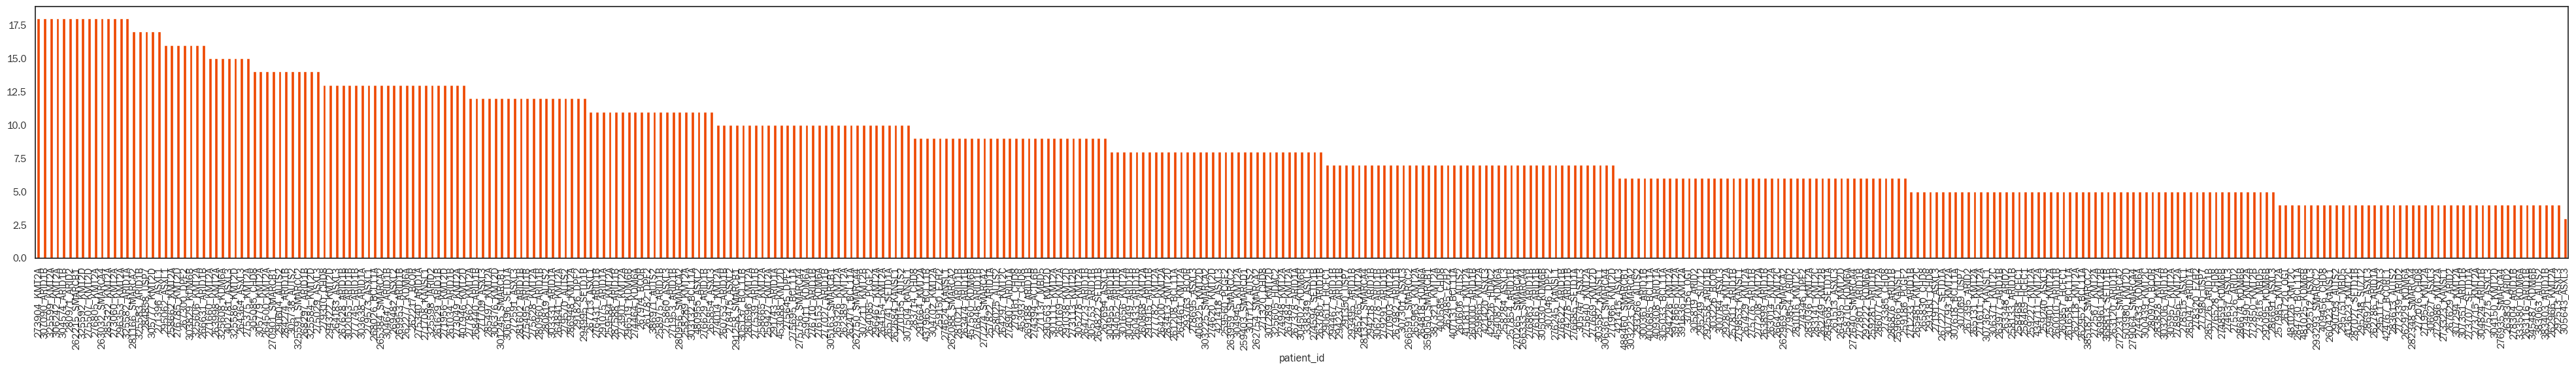

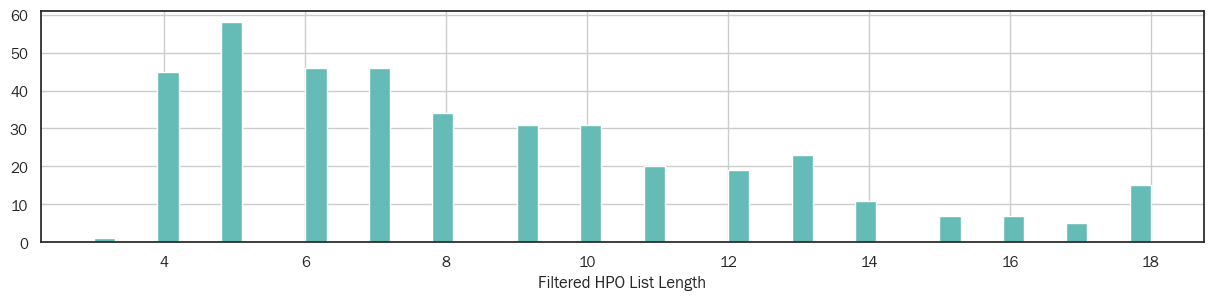

<Figure size 10000x300 with 0 Axes>

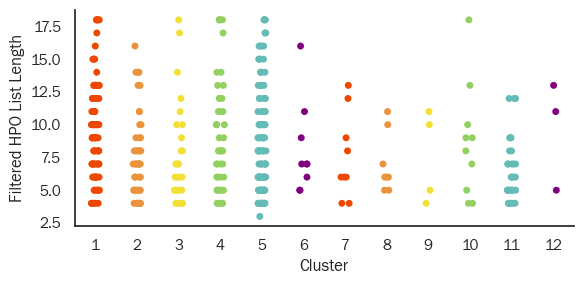

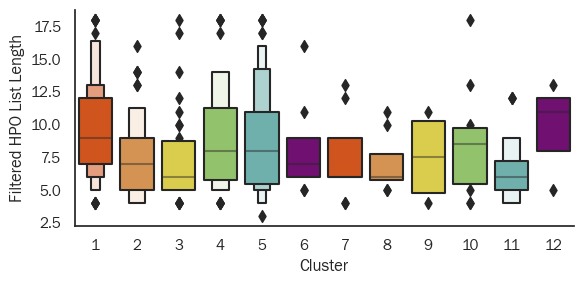

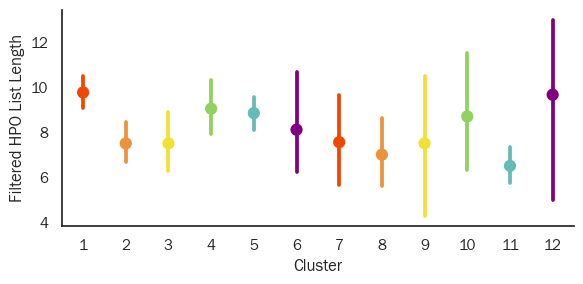

In [16]:
# Order decipher by filtered_hpo_list_length.
decipher_data_filtered = decipher_data_filtered.sort_values(by='filtered_hpo_list_length', ascending=False)

# Plot a bar graph with the length of filtered_hpo_list per gene
plt.figure()
sns.set_theme(style='white', font="Franklin Gothic Book",font_scale=1, palette=['#ee4800'])
decipher_data_filtered.plot.bar(x='patient_id', y='filtered_hpo_list_length', rot=90, figsize=(50, 5), legend=False)

# Plot a histogram 
plt.figure(figsize=(15, 3))
sns.set_theme(style='white', font="Franklin Gothic Book",font_scale=1, palette=['#65bbb5'])
decipher_data_filtered['filtered_hpo_list_length'].hist(bins=50)
plt.xlabel('Filtered HPO List Length')

# Plot a categorical plots of filtered_hpo_list_length and the cluster number
plt.figure(figsize=(100, 3))
sns.set_theme(style='white', font="Franklin Gothic Book", font_scale=1)
sns.catplot(x='cluster', y='filtered_hpo_list_length', data=decipher_data_filtered, palette=['#ee4800', '#ea933c', '#f2e036', '#92d05f', '#65bbb5', 'purple'], height=3, aspect=2)
plt.ylabel('Filtered HPO List Length')
plt.xlabel('Cluster')
sns.catplot(x='cluster', y='filtered_hpo_list_length', data=decipher_data_filtered, palette=['#ee4800', '#ea933c', '#f2e036', '#92d05f', '#65bbb5', 'purple'], height=3, aspect=2, kind='boxen')
plt.ylabel('Filtered HPO List Length')
plt.xlabel('Cluster')
sns.catplot(x='cluster', y='filtered_hpo_list_length', data=decipher_data_filtered, palette=['#ee4800', '#ea933c', '#f2e036', '#92d05f', '#65bbb5', 'purple'], height=3, aspect=2, kind='point')
plt.ylabel('Filtered HPO List Length')
plt.xlabel('Cluster')

# Group the df by cluster and count the number of patients in each cluster.
decipher_cluster_count = decipher_data_filtered.groupby('cluster').count()

# -------------------------------------------------------------------

### **Phenotypic comparison across the 12 clusters**
- Separate patients into different cluster dataframes

In [17]:
# Split dataframe by cluster, starting with largest cluster
decipher_cluster_1 = decipher_data_filtered[decipher_data_filtered['cluster'] == 5] 
decipher_cluster_2 = decipher_data_filtered[decipher_data_filtered['cluster'] == 1]
decipher_cluster_3 = decipher_data_filtered[decipher_data_filtered['cluster'] == 2]
decipher_cluster_4 = decipher_data_filtered[decipher_data_filtered['cluster'] == 4]
decipher_cluster_5 = decipher_data_filtered[decipher_data_filtered['cluster'] == 11]
decipher_cluster_6 = decipher_data_filtered[decipher_data_filtered['cluster'] == 3]
decipher_cluster_7 = decipher_data_filtered[decipher_data_filtered['cluster'] == 10]
decipher_cluster_8 = decipher_data_filtered[decipher_data_filtered['cluster'] == 6]
decipher_cluster_9 = decipher_data_filtered[decipher_data_filtered['cluster'] == 7]
decipher_cluster_10 = decipher_data_filtered[decipher_data_filtered['cluster'] == 8]
decipher_cluster_11 = decipher_data_filtered[decipher_data_filtered['cluster'] == 9]
decipher_cluster_12 = decipher_data_filtered[decipher_data_filtered['cluster'] == 12]

# Get frequency of patients in each cluster
cluster_freqs = [(len(decipher_cluster_1)), (len(decipher_cluster_2)), (len(decipher_cluster_3)), (len(decipher_cluster_4)), (len(decipher_cluster_5)), (len(decipher_cluster_6)),
                 (len(decipher_cluster_7)), (len(decipher_cluster_8)), (len(decipher_cluster_9)), (len(decipher_cluster_10)), (len(decipher_cluster_11)), (len(decipher_cluster_12))]

# Identify the HPO terms across all clusters
all_HPOTerms = set()
decipher_data_filtered['propagated_terms'].str.split("|").apply(all_HPOTerms.update)
freq_HPOTerms = len(list(all_HPOTerms))

- Get the frequency & percentage occurance of each HPO term in each cluster
- Identify which terms are significantly increased in each cluster when compared to all other clusters as a group

In [19]:
clusters_freq = pd.DataFrame({'hpo_term': list(get_HPOID_cluster_freq(decipher_cluster_1).keys()), 
                              'cluster_1_freq': list(get_HPOID_cluster_freq(decipher_cluster_1).values()), 
                              'cluster_2_freq': list(get_HPOID_cluster_freq(decipher_cluster_2).values()), 
                              'cluster_3_freq': list(get_HPOID_cluster_freq(decipher_cluster_3).values()),
                              'cluster_4_freq': list(get_HPOID_cluster_freq(decipher_cluster_4).values()), 
                              'cluster_5_freq': list(get_HPOID_cluster_freq(decipher_cluster_5).values()), 
                              'cluster_6_freq': list(get_HPOID_cluster_freq(decipher_cluster_6).values()), 
                              'cluster_7_freq': list(get_HPOID_cluster_freq(decipher_cluster_7).values()), 
                              'cluster_8_freq': list(get_HPOID_cluster_freq(decipher_cluster_8).values()), 
                              'cluster_9_freq': list(get_HPOID_cluster_freq(decipher_cluster_9).values()),
                              'cluster_10_freq': list(get_HPOID_cluster_freq(decipher_cluster_10).values()), 
                              'cluster_11_freq': list(get_HPOID_cluster_freq(decipher_cluster_11).values()), 
                              'cluster_12_freq': list(get_HPOID_cluster_freq(decipher_cluster_12).values())})

# Calculate percentages
for i in range(1,13):
    clusters_freq["cluster_"+str(i)+"_percent"] = (clusters_freq["cluster_"+str(i)+"_freq"])/cluster_freqs[i-1]

# Get HPO Terms increased in each cluster
for i in range(1,13):
    get_sigincreased_HPOTerms_cluster(i)

NameError: name 'get_HPOID_cluster_freq' is not defined

# -------------------------------------------------------------------

### **Visualise phenotypic differences across the 12 clusters**
- Filter dataframe to prepare data for visualisation

In [ ]:
# Get HPO terms present in at least 10% of patients in at least one cluster
clusters_freq_subset = clusters_freq[(clusters_freq['cluster_1_percent']>0.1) | (clusters_freq['cluster_2_percent']>0.1)|(clusters_freq['cluster_3_percent']>0.1)| 
                                     (clusters_freq['cluster_4_percent']>0.1) | (clusters_freq['cluster_5_percent']>0.1)|(clusters_freq['cluster_6_percent']>0.1)| 
                                     (clusters_freq['cluster_7_percent']>0.1) | (clusters_freq['cluster_8_percent']>0.1)|(clusters_freq['cluster_9_percent']>0.1)| 
                                     (clusters_freq['cluster_10_percent']>0.1)|(clusters_freq['cluster_11_percent']>0.1)|(clusters_freq['cluster_12_percent']>0.1)]

# Get p-values in each cluster for each HPO term
clusters_freq_pvals = clusters_freq_subset[["hpo_term", "cluster_1_sig_indicate", "cluster_2_sig_indicate", "cluster_3_sig_indicate", "cluster_4_sig_indicate", 
                                            "cluster_5_sig_indicate", "cluster_6_sig_indicate", "cluster_7_sig_indicate", "cluster_8_sig_indicate", 
                                            "cluster_9_sig_indicate", "cluster_10_sig_indicate", "cluster_11_sig_indicate", "cluster_12_sig_indicate"]]

# Get percentage occurance in each cluster for each HPO term
clusters_freq_phenotypes = clusters_freq_subset[["hpo_term", "cluster_1_percent", "cluster_2_percent", "cluster_3_percent", "cluster_4_percent", 
                                                 "cluster_5_percent", "cluster_6_percent", "cluster_7_percent", "cluster_8_percent", 
                                                 "cluster_9_percent", "cluster_10_percent", "cluster_11_percent", "cluster_12_percent"]]

# Rename for visualisation
clusters_freq_phenotypes = clusters_freq_phenotypes.rename(columns={'cluster_1_percent':f'Cluster 1 (n={cluster_freqs[0]})', 'cluster_2_percent':f'Cluster 2 (n={cluster_freqs[1]})', 'cluster_3_percent':f'Cluster 3 (n={cluster_freqs[2]})', 
                                                            'cluster_4_percent':f'Cluster 4 (n={cluster_freqs[3]})', 'cluster_5_percent':f'Cluster 5 (n={cluster_freqs[4]})', 'cluster_6_percent':f'Cluster 6 (n={cluster_freqs[5]})', 
                                                            'cluster_7_percent':f'Cluster 7 (n={cluster_freqs[6]})', 'cluster_8_percent':f'Cluster 8 (n={cluster_freqs[7]})', 'cluster_9_percent':f'Cluster 9 (n={cluster_freqs[8]})', 
                                                            'cluster_10_percent':f'Cluster 10 (n={cluster_freqs[9]})', 'cluster_11_percent':f'Cluster 11 (n={cluster_freqs[10]})', 'cluster_12_percent':f'Cluster 12 (n={cluster_freqs[11]})'})

# Reset indices
clusters_freq_phenotypes = clusters_freq_phenotypes.set_index("hpo_term")
clusters_freq_pvals = clusters_freq_pvals.set_index("hpo_term")

- Visualise the prevelance of the 6 identified top-level HPO terms across the 12 clusters

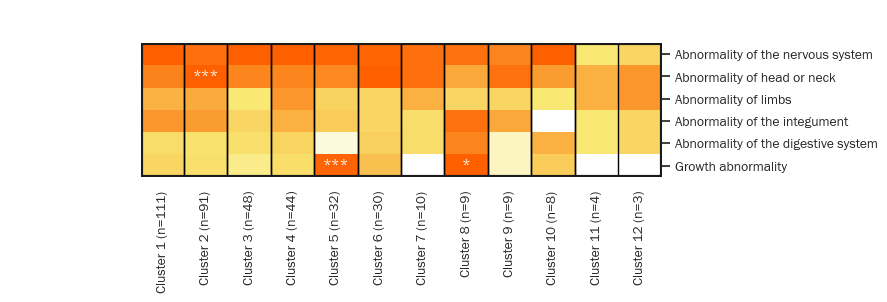

In [ ]:
# Filter for top-level HPO terms list
topLevel_phenotypes_list = ("Abnormality of the nervous system", "Abnormality of head or neck",  "Abnormality of limbs", "Abnormality of the integument", "Abnormality of the digestive system", "Growth abnormality")
clusters_freq_phenotypes_filtered  = clusters_freq_phenotypes[clusters_freq_phenotypes.index.isin(topLevel_phenotypes_list)]
clusters_freq_phenotypes_filtered.index = (pd.Categorical(clusters_freq_phenotypes_filtered.index, categories=topLevel_phenotypes_list, ordered=True))
clusters_freq_phenotypes_filtered = clusters_freq_phenotypes_filtered.sort_index()

clusters_freq_pvals_filtered  = clusters_freq_pvals[clusters_freq_pvals.index.isin(topLevel_phenotypes_list)]
clusters_freq_pvals_filtered.index = pd.Categorical(clusters_freq_pvals_filtered.index, categories=topLevel_phenotypes_list, ordered=True)
clusters_freq_pvals_filtered = clusters_freq_pvals_filtered.sort_index()

# Plot heatmap
cmap = LinearSegmentedColormap.from_list('custom', [(0, 'white'), (0.25, '#f9e873'), (0.5, '#fab142'), (1, '#fe6000')], N=256)

sns.set_style("white")
sns.set_theme(font_scale=0.9, font="Franklin Gothic Book")
heatmap = sns.clustermap(clusters_freq_phenotypes_filtered, cmap=cmap, method="ward", annot=clusters_freq_pvals_filtered, figsize=(9, 3.15), row_cluster=False, col_cluster=False, fmt="")

ax = heatmap.ax_heatmap
ax.add_patch(Rectangle((0,0 ), 1, 200, fill=False, edgecolor='black', lw=1))
ax.add_patch(Rectangle((1,0 ), 1, 200, fill=False, edgecolor='black', lw=1))
ax.add_patch(Rectangle((2,0 ), 1, 200, fill=False, edgecolor='black', lw=1))
ax.add_patch(Rectangle((3,0 ), 1, 200, fill=False, edgecolor='black', lw=1))
ax.add_patch(Rectangle((4,0 ), 1, 200, fill=False, edgecolor='black', lw=1))
ax.add_patch(Rectangle((5,0 ), 1, 200, fill=False, edgecolor='black', lw=1))
ax.add_patch(Rectangle((6,0 ), 1, 200, fill=False, edgecolor='black', lw=1))
ax.add_patch(Rectangle((7,0 ), 1, 200, fill=False, edgecolor='black', lw=1))
ax.add_patch(Rectangle((8,0 ), 1, 200, fill=False, edgecolor='black', lw=1))
ax.add_patch(Rectangle((9,0 ), 1, 200, fill=False, edgecolor='black', lw=1))
ax.add_patch(Rectangle((10,0 ), 1, 200, fill=False, edgecolor='black', lw=1))

ax.axhline(y = 0, color='k',linewidth = 3) 
ax.axhline(y = 6, color = 'k', linewidth = 3) 
ax.axvline(x = 0, color = 'k', linewidth = 3) 
ax.axvline(x = 12, color = 'k', linewidth = 3)

heatmap.cax.set_visible(False)
plt.savefig('cluster_heatmap_top_level.png', dpi=600)
plt.show()

- Visualise key differences between the 12 clusters

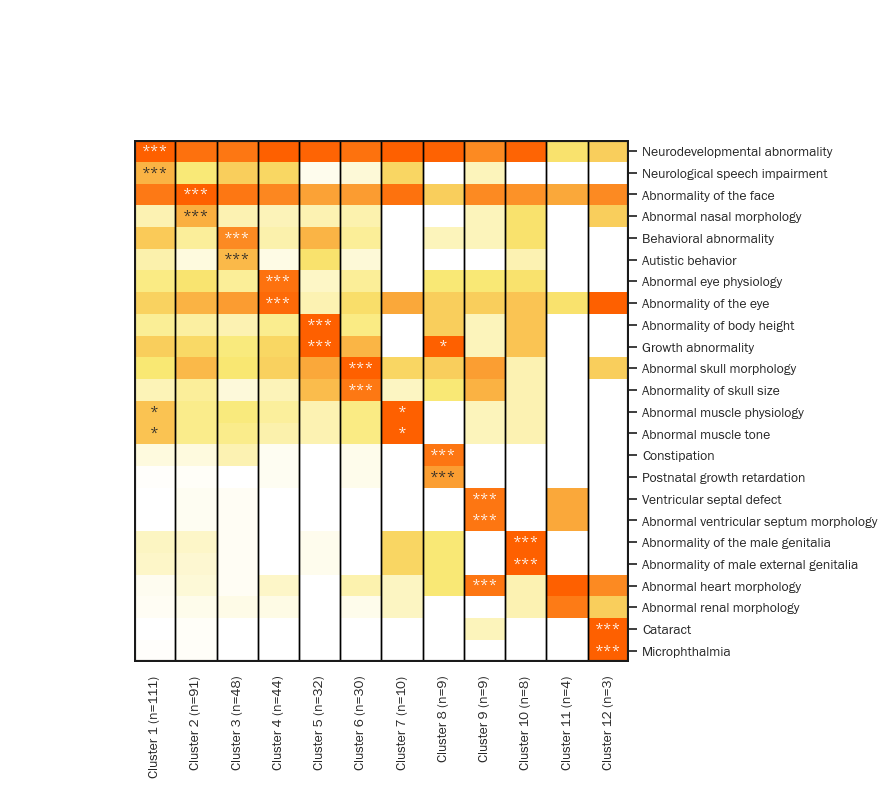

In [ ]:
# Get top 2 HPO terms for each cluster by smallest p-value
top_phenotypes = []
for i in range(1,13):
    top_cluster = clusters_freq.sort_values(by='cluster_'+str(i)+'_adj_p_value', ascending=True)['hpo_term'].head(n=2).to_list()
    top_phenotypes.append(top_cluster)
top_phenotypes_flat_list = [item for sublist in top_phenotypes for item in sublist]

# Filter using HPO terms list
clusters_freq_phenotypes_filtered  = clusters_freq_phenotypes[clusters_freq_phenotypes.index.isin(top_phenotypes_flat_list)]
clusters_freq_phenotypes_filtered.index = pd.Categorical(clusters_freq_phenotypes_filtered.index, categories=top_phenotypes_flat_list, ordered=True)
clusters_freq_phenotypes_filtered = clusters_freq_phenotypes_filtered.sort_index()

clusters_freq_pvals_filtered  = clusters_freq_pvals[clusters_freq_pvals.index.isin(top_phenotypes_flat_list)]
clusters_freq_pvals_filtered.index = pd.Categorical(clusters_freq_pvals_filtered.index, categories=top_phenotypes_flat_list, ordered=True)
clusters_freq_pvals_filtered = clusters_freq_pvals_filtered.sort_index()

# Plot heatmap
cmap = LinearSegmentedColormap.from_list('custom', [(0, 'white'), (0.25, '#f9e873'), (0.5, '#fab142'), (1, '#fe6000')], N=256)
sns.set_style("white")
sns.set_theme(font_scale=0.9, font="Franklin Gothic Book")
heatmap = sns.clustermap(clusters_freq_phenotypes_filtered, cmap=cmap, method="ward", annot=clusters_freq_pvals_filtered, figsize=(9,8), row_cluster=False, col_cluster=False, vmin=0.0, vmax=0.9, fmt="")

ax = heatmap.ax_heatmap
ax.add_patch(Rectangle((0,0 ), 1, 200, fill=False, edgecolor='black', lw=1))
ax.add_patch(Rectangle((1,0 ), 1, 200, fill=False, edgecolor='black', lw=1))
ax.add_patch(Rectangle((2,0 ), 1, 200, fill=False, edgecolor='black', lw=1))
ax.add_patch(Rectangle((3,0 ), 1, 200, fill=False, edgecolor='black', lw=1))
ax.add_patch(Rectangle((4,0 ), 1, 200, fill=False, edgecolor='black', lw=1))
ax.add_patch(Rectangle((5,0 ), 1, 200, fill=False, edgecolor='black', lw=1))
ax.add_patch(Rectangle((6,0 ), 1, 200, fill=False, edgecolor='black', lw=1))
ax.add_patch(Rectangle((7,0 ), 1, 200, fill=False, edgecolor='black', lw=1))
ax.add_patch(Rectangle((8,0 ), 1, 200, fill=False, edgecolor='black', lw=1))
ax.add_patch(Rectangle((9,0 ), 1, 200, fill=False, edgecolor='black', lw=1))
ax.add_patch(Rectangle((10,0 ), 1, 200, fill=False, edgecolor='black', lw=1))
ax.add_patch(Rectangle((11,0 ), 1, 200, fill=False, edgecolor='black', lw=1))
ax.add_patch(Rectangle((12,0 ), 1, 200, fill=False, edgecolor='black', lw=1))

ax.axhline(y = 0, color='k',linewidth = 3) 
ax.axhline(y = 24, color = 'k', linewidth = 3) 
ax.axvline(x = 0, color = 'k', linewidth = 3) 
ax.axvline(x = 12, color = 'k', linewidth = 3)

heatmap.cax.set_visible(False)
plt.savefig('cluster_heatmap.png', dpi=600)
plt.show()

In [ ]:
from PIL import Image

im = Image.open("cluster_heatmap.png".format())
im = im.crop((825, 875, 5500, 4800))
im.save("cluster_heatmap_crop.png".format())

im = Image.open("cluster_heatmap_top_level.png".format())
im = im.crop((875, 280, 5950, 1150)) 
im.save("cluster_heatmap_top_level_crop.png".format())

# -------------------------------------------------------------------